In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [3]:
#Настройка графиков
%matplotlib inline
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
       'weight' : 'bold',
        'size' : 14}
mpl.rc('font', **font)

In [4]:
data = pd.read_csv('/home/violett/Downloads/ab_test_inference/ab_test_ensembles.csv')
data.head()
# group: control treatment
#variants: standard svm_ensemble_v_1_22
#user_type: registered_user new_user
#RangeIndex: 294478 entries, 0 to 294477

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [5]:
required_treatment =data[data['group']=='treatment'].count()
print(required_treatment)
required_control =data[data['group']=='control'].count()
print(required_control)
#Взяли меньшее количество пользователй из контрольной группы
required_n=147202

user_id      147276
timestamp    147276
group        147276
variants     147276
converted    147276
location     147276
age_group    147276
user_type    147276
dtype: int64
user_id      147202
timestamp    147202
group        147202
variants     147202
converted    147202
location     147202
age_group    147202
user_type    147202
dtype: int64


In [26]:
pd.crosstab(data['group'],data['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


In [27]:
sessions = data['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(duplicate_users)

0


In [28]:
control_sample = data[data['group']=='control'].sample(n = required_n, random_state=42)
treatment_sample = data[data['group']=='treatment'].sample(n=required_n, random_state=42)
ab_data=pd.concat([control_sample, treatment_sample], axis=0)
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294404 entries, 236870 to 97820
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294404 non-null  object
 1   timestamp  294404 non-null  object
 2   group      294404 non-null  object
 3   variants   294404 non-null  object
 4   converted  294404 non-null  int64 
 5   location   294404 non-null  object
 6   age_group  294404 non-null  object
 7   user_type  294404 non-null  object
dtypes: int64(1), object(7)
memory usage: 20.2+ MB


In [29]:
ab_data.group.value_counts(normalize=True)

control      0.5
treatment    0.5
Name: group, dtype: float64

In [30]:
conversion_rates=ab_data.groupby('group')['converted']
#Standart deviation
std_proportional = lambda x: np.std(x, ddof=0)
#
se_proportional= lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportional, se_proportional]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.120399,0.325428,0.000848
treatment,0.118911,0.323684,0.000844


Text(0, 0.5, 'Converted (proportion)')

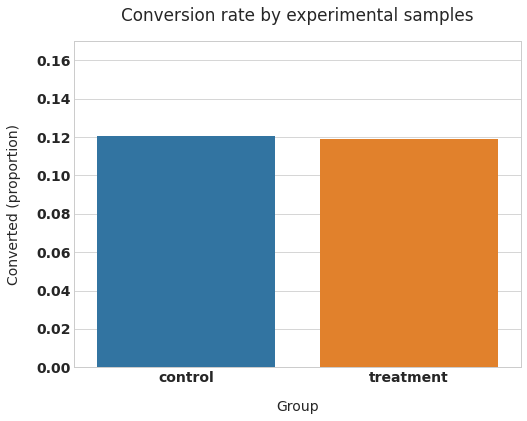

In [31]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_data['group'], y=ab_data['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversasion rate by experimental samples', pad=20)
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group',labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15)

In [32]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_data[ab_data['group'] == 'control']['converted']
treatment_results = ab_data[ab_data['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: 1.24
p-value: 0.214
CI 95% for control group: [0.119, 0.122]
CI 95% for treatment group: [0.117, 0.121]


# Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22?
Так как наше p-значение = 0.214 что значительно больше 0.05, то согласно статистическому выводу, 
мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.

Доверительный интервал для испытуемой группы [0.117, 0.121];
Доверительный интервал для контрольной группы [0.119, 0.122]

Результат можно интпритировать следующим образом: изменение сайта никак не влияет на уровень конверсии


In [33]:
#Старые новые пользователи
pd.crosstab(data['group'],data['user_type'])

user_type,new_user,registered_user
group,,
control,73750,73452
treatment,73488,73788


In [34]:

conversion_rates=ab_data.groupby('user_type')['converted']
#Standart deviation
std_proportional = lambda x: np.std(x, ddof=0)
#
se_proportional= lambda x: stats.sem(x, ddof=0)
conversion_rates = conversion_rates.agg([np.mean, std_proportional, se_proportional]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
user_type,,,
new_user,0.119142,0.323956,0.000844
registered_user,0.120168,0.325158,0.000847


In [35]:
control_sample = data[data['user_type']=='new_user'].sample(n = required_n, random_state=42)
treatment_sample = data[data['user_type']=='registered_user'].sample(n=required_n, random_state=42)
ab_data=pd.concat([control_sample, treatment_sample], axis=0)
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294404 entries, 293509 to 7767
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294404 non-null  object
 1   timestamp  294404 non-null  object
 2   group      294404 non-null  object
 3   variants   294404 non-null  object
 4   converted  294404 non-null  int64 
 5   location   294404 non-null  object
 6   age_group  294404 non-null  object
 7   user_type  294404 non-null  object
dtypes: int64(1), object(7)
memory usage: 20.2+ MB


In [ ]:
plt.figure(figsize=(8,6));
sns.barplot(x=ab_data['user_type'], y=ab_data['converted'], ci=False);
plt.ylim(0, 0.17);
plt.title('Conversasion rate by experimental samples', pad=20)
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('User Type',labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15)

In [38]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_data[ab_data['user_type'] == 'new_user']['converted']
treatment_results = ab_data[ab_data['user_type'] == 'registered_user']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.83
p-value: 0.407
CI 95% for control group: [0.117, 0.121]
CI 95% for treatment group: [0.118, 0.122]


# Cтоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Так как наше p-значение = 0.407 что значительно больше 0.05, 
то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, 
что означает что новый пользователь или старый не влияет на уровень конверсии.

Доверительный интервал для испытуемой группы [0.117, 0.121]. 
Доверительный интервал для контрольной группы [0.118, 0.122]

Результат можно интпритировать следующим образом: нет разницы для старых и новых пользователей сайта
никак не влияет на уровень конверсии
